In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.stats import stats
from scipy.stats.stats import pearsonr
from statsmodels.stats.multitest import multipletests as fdr

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb
import matplotlib.font_manager as fm
%matplotlib inline

from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
from enigmatoolbox.utils.parcellation import parcel_to_surface
import warnings
warnings.filterwarnings("ignore")

## Load files

In [2]:
## set dirs
base_dir = '/Volumes/GoogleDrive/My Drive/Gradient_Shift_Cellular_Basis/Milgram'
gradient_dir = base_dir+'/data/Gradients_Margulies2016'
figure_dir = base_dir+'/figures/permcca'
data_dir = base_dir+'/data/permcca'
net_enrich_dir = base_dir+'/data/NetworkEnrichment'

In [3]:
## 1. load the 18 cell-types
LakeDFC_schaefer400 = pd.read_csv(gradient_dir+'/schaeffer_LAKE_DFC_400_7Net_expr_mat_new_NormZscore0.3.csv',header=None,index_col=0)
LakeVIS_schaefer400 = pd.read_csv(gradient_dir+'/schaeffer_LAKE_VIS_400_7Net_expr_mat_new_NormZscore0.3.csv',header=0,index_col=0)
# drop NaN columns in empirical cell type fractions
LakeDFC_schaefer400_drop = LakeDFC_schaefer400.dropna(axis=1)
LakeVIS_schaefer400_drop = LakeVIS_schaefer400.dropna(axis=1)
# 0~190: LH
# 191~339: RH
# remove the Ex2 from Lake_DFC and In2 from Lake_VIS
LakeDFC_schaefer400_drop = LakeDFC_schaefer400_drop.drop(index=('DFC_Ex2'))
LakeVIS_schaefer400_drop = LakeVIS_schaefer400_drop.drop(index=('VIS_In2'))
# name list of row names (cell-type)
cell_types_DFC = list(LakeDFC_schaefer400_drop.index.values)
cell_types_VIS = list(LakeVIS_schaefer400_drop.index.values)
# extract the values
LakeDFC_schaefer400_mat = LakeDFC_schaefer400_drop.to_numpy()
LakeVIS_schaefer400_mat = LakeVIS_schaefer400_drop.to_numpy()

## 2. load the labels for the Schaefer networks
schaefer400_7Networks = pd.read_csv(gradient_dir+'/schaefer_400_7Net_labels_manually_added.csv',header=None,index_col=0)
# dropped version of it
schaefer400_7Networks_drop = pd.read_csv(net_enrich_dir + '/schaefer400_7Networks_NaNDropped.csv',header=0,index_col=0)
schaefer400_7Networks_mat = schaefer400_7Networks_drop.to_numpy()
schaefer400_7Networks_mat_left = schaefer400_7Networks_mat[:191,:]

## 3. load the cca variables
U_V_table = pd.read_csv(data_dir+'/U_V_table.csv',header=0,index_col=None)
loading_DFC_table  = pd.read_csv(data_dir+'/loading_DFC_table.csv',header=0,index_col=0)
loading_VIS_table  = pd.read_csv(data_dir+'/loading_VIS_table.csv',header=0,index_col=0)
cca_p_r_table = pd.read_csv(data_dir+'/cca_p_r_table.csv',header=0,index_col=None)

## Functions to make plot

In [4]:
def SurfPlot_left(parcel_accuracy, full_parcel_table, file_name):#, cmin, cmax
    # Fill the parcel accuracy back to surface
    left = np.zeros(200)
    left[full_parcel_table.loc[:,:200].notnull().any()] = parcel_accuracy
    left = parcel_to_surface(np.concatenate((left,np.zeros(200)),axis=0), 'schaefer_400_fsa6')
    
    # set up the surface plot base
    p_left = Plot(surf_lh=lh,size=(1400, 500), zoom=1.7)
    lh_left = left[:vertex_per_hemi]
    # add layer for the K-Means Label
    p_left.add_layer(np.transpose(lh_left), cmap='viridis') #cbar_label='Default mode'#,color_range=(cmin,cmax)
    # add layer for the schaefer 400 pacels outline
    p_left.add_layer(lh_schaefer400, cmap='gray', as_outline=True, cbar=False)
    # set label properties
    kws = {'location': 'left',  'decimals': 2, 'shrink': .5,
           'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
           'draw_border': True} #'label_direction': 45,'shrink': .15,
    fig = p_left.build(cbar_kws=kws)
    fig.savefig(figure_dir+f'/{file_name}.pdf',transparent=True)

In [5]:
def SurfPlot_full(parcel_accuracy, full_parcel_table, file_name):

    # Fill the cluster membership back to surface
    full = np.zeros(400)
    full[full_parcel_table.notnull().any()] = parcel_accuracy
    full = parcel_to_surface(np.concatenate((full,np.zeros(400)),axis=0), 'schaefer_400_fsa6')

    # set up the surface plot base
    p_full = Plot(lh, rh,size=(1400, 1000), zoom=1.7)
    lh_full = full[:vertex_per_hemi]
    rh_full = full[vertex_per_hemi:]
    # add layer for the K-Means Label
    p_full.add_layer({'left': np.transpose(lh_full), 'right': np.transpose(rh_full)}, cmap='viridis') #cbar_label='Default mode'
    # add layer for the schaefer 400 pacels outline
    p_full.add_layer({'left':lh_schaefer400, 'right':rh_schaefer400}, cmap='gray', as_outline=True, cbar=False)
    # set label properties
    kws = {'decimals': 2, 'shrink': .5,
           'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
           'draw_border': True} #'label_direction': 45,'shrink': .15,
    fig = p_full.build(cbar_kws=kws)#
    fig.savefig(figure_dir+f'/{file_name}.pdf',transparent=True)

In [6]:
# download surfaces:
surfaces = fetch_fslr()
#surfaces = fetch_fslr(density='164k')
# check the available surfaces:
#surfaces.keys()
#---- output ----
# dict_keys(['midthickness', 'inflated', 'veryinflated', 'sphere', 'medial', 'sulc', 'vaavg'])
#---- output ----

# load schaefer parcellation labels (in fsaverage6)
lh_schaefer400, rh_schaefer400 = load_parcellation('schaefer')
# each vertex stores the corresponding parcel label
#lh_parc.shape
#---- output ----
# (32492,)
#---- output ----

# for gradients, vary inflated version can best visualize the details
lh, rh = surfaces['veryinflated']

vertex_per_hemi = len(lh_schaefer400)

schaefer400_7Networks_fsaverage6 = parcel_to_surface(schaefer400_7Networks[1].to_numpy(), 'schaefer_400_fsa6')

network_names = ['Visual','Som/Motor','DorsAttn','Sal/VentAttn','Limbic','Control','Default']

## Plot the V (Linear combinations of all celltypes)
### 1. Gradient 1

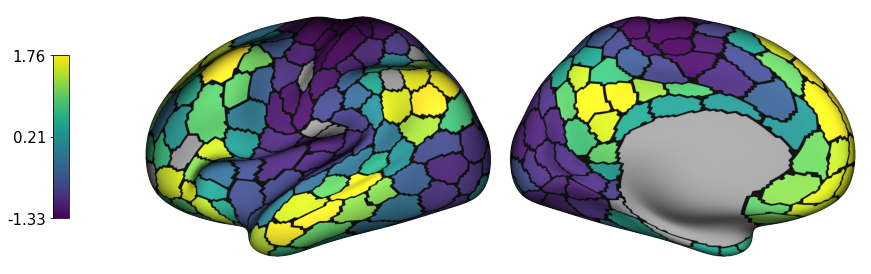

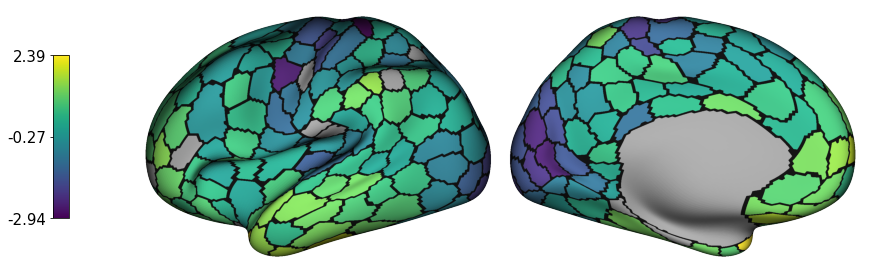

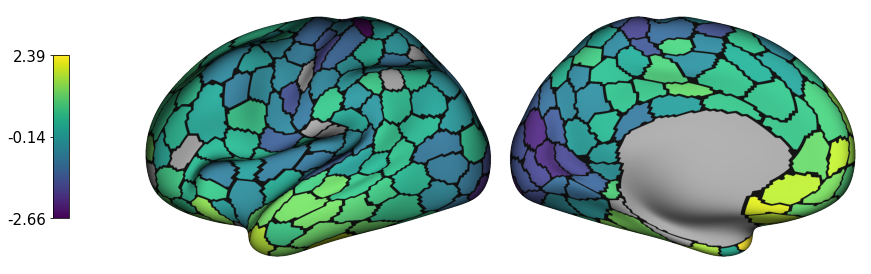

In [8]:
# Gradient 1
SurfPlot_left(U_V_table['U_G1_DFC'][0:191], LakeDFC_schaefer400, 'G1_SurfLeft')
# Lake_DFC imputed cell distribution
SurfPlot_left(U_V_table['V_G1_DFC'][0:191], LakeDFC_schaefer400, 'CelltypeScore_G1_DFC_SurfLeft')
# Lake_VIS imputed cell distribution
SurfPlot_left(U_V_table['V_G1_VIS'][0:191], LakeDFC_schaefer400, 'CelltypeScore_G1_VIS_SurfLeft')

### Gradient 2

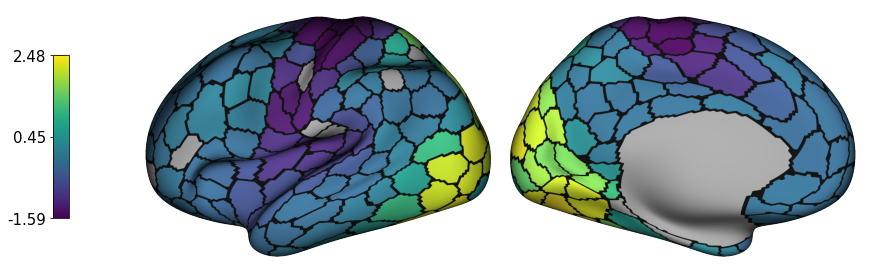

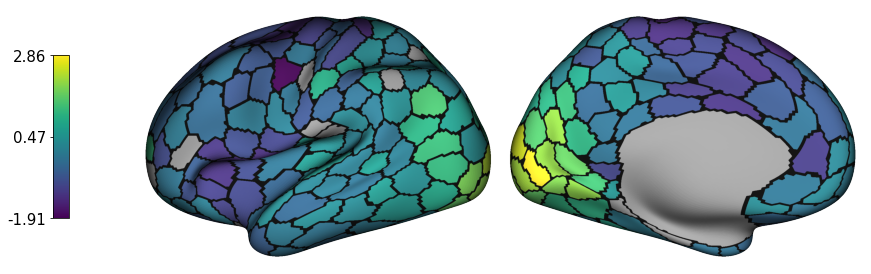

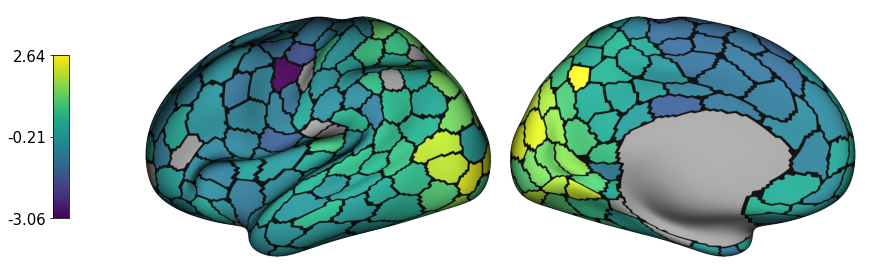

In [9]:
SurfPlot_left(-U_V_table['U_G2_DFC'][0:191], LakeDFC_schaefer400, 'G2_SurfLeft')
SurfPlot_left(-U_V_table['V_G2_DFC'][0:191], LakeDFC_schaefer400, 'CelltypeScore_G2_DFC_SurfLeft')
SurfPlot_left(-U_V_table['V_G2_VIS'][0:191], LakeDFC_schaefer400, 'CelltypeScore_G2_VIS_SurfLeft')

## Plot the loadings (diverging bar graph)

In [7]:
loading_DFC_table

,loading_G1,loading_G1_p,loading_G2,loading_G2_p
Row,,,,
Ex1,0.307448,7.451939e-09,-0.056858,2.965552e-01
Ex3,0.102544,5.929004e-02,0.244589,5.210890e-06
Ex4,-0.133951,1.357500e-02,-0.374552,9.888112e-13
Ex5,0.103888,5.601874e-02,0.069629,2.009581e-01
Ex6,-0.061187,2.612426e-01,0.133056,1.421901e-02
Ex8,0.017240,7.517907e-01,0.179474,9.025802e-04
In1,0.309443,5.889197e-09,0.137547,1.123762e-02
In3,-0.119889,2.729943e-02,-0.198966,2.271332e-04
In4,-0.141256,9.207424e-03,-0.049647,3.621466e-01


In [8]:
def DivergingBarGraph(table, loading, p, fig_name):
    
    # sort the loadingsfrom positive to negative
    table = table.sort_values(by=[loading], ascending=False)
    
    # pull out the labels
    labels = list(table.index)
    
    # specify colors:
    for i in range(len(table)):
        # Colour of bar chart is set to red if positive and blue for negative
        table['colors'] = ['red' if x > 0 else 'blue' for x in table[loading]]
        
    # plot parameters:
    nrows = 1
    ncols = 1
    dpi = 300
    tight = True
    # set up the figure
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=[5,10], dpi=dpi, constrained_layout=tight)
    
    # make the bar plot
    sns.set_style(style="white")
    ax = sns.barplot(x=table[loading], y=labels, edgecolor='black')
    
    # rename the x-axis
    ax.set(xlabel='Cell type loading')
    
    # reset color for each bar
    for bar, color in zip(ax.containers[0], table['colors']):
        bar.set_facecolor(color)
        
    # add significant star to each bar
    space = 0.01
    text_posit = "center"
    offset = 0.15
    for i in range(len(table)):
        if table[p][i] < (0.05/len(table)): # FDR correction for multiple comparisons
            patch = ax.patches[i]
            _y = patch.get_y() + patch.get_height()/2 + offset
            if table[loading][i] < 0:
                _x = patch.get_x() + patch.get_width() - float(space)
            else:
                _x = patch.get_x() + patch.get_width() + float(space)
                
            ax.text(_x, _y, '*', ha=text_posit)

    

    
    # add the grid
    lw = 0.5
    color = 'k'
    vline_positions = np.arange(-0.4,0.4,0.1)
    for v in vline_positions:
        ax.axvline(v, linewidth=lw, color=color, dashes=(1, 4))
    # add the 0 line
    ax.axvline(0,  linewidth=1, color=color, dashes=(1, 0))
    
    # display set up
    plt.tight_layout()
    # save it
    plt.savefig(figure_dir+f'/{fig_name}.pdf',transparent=True)

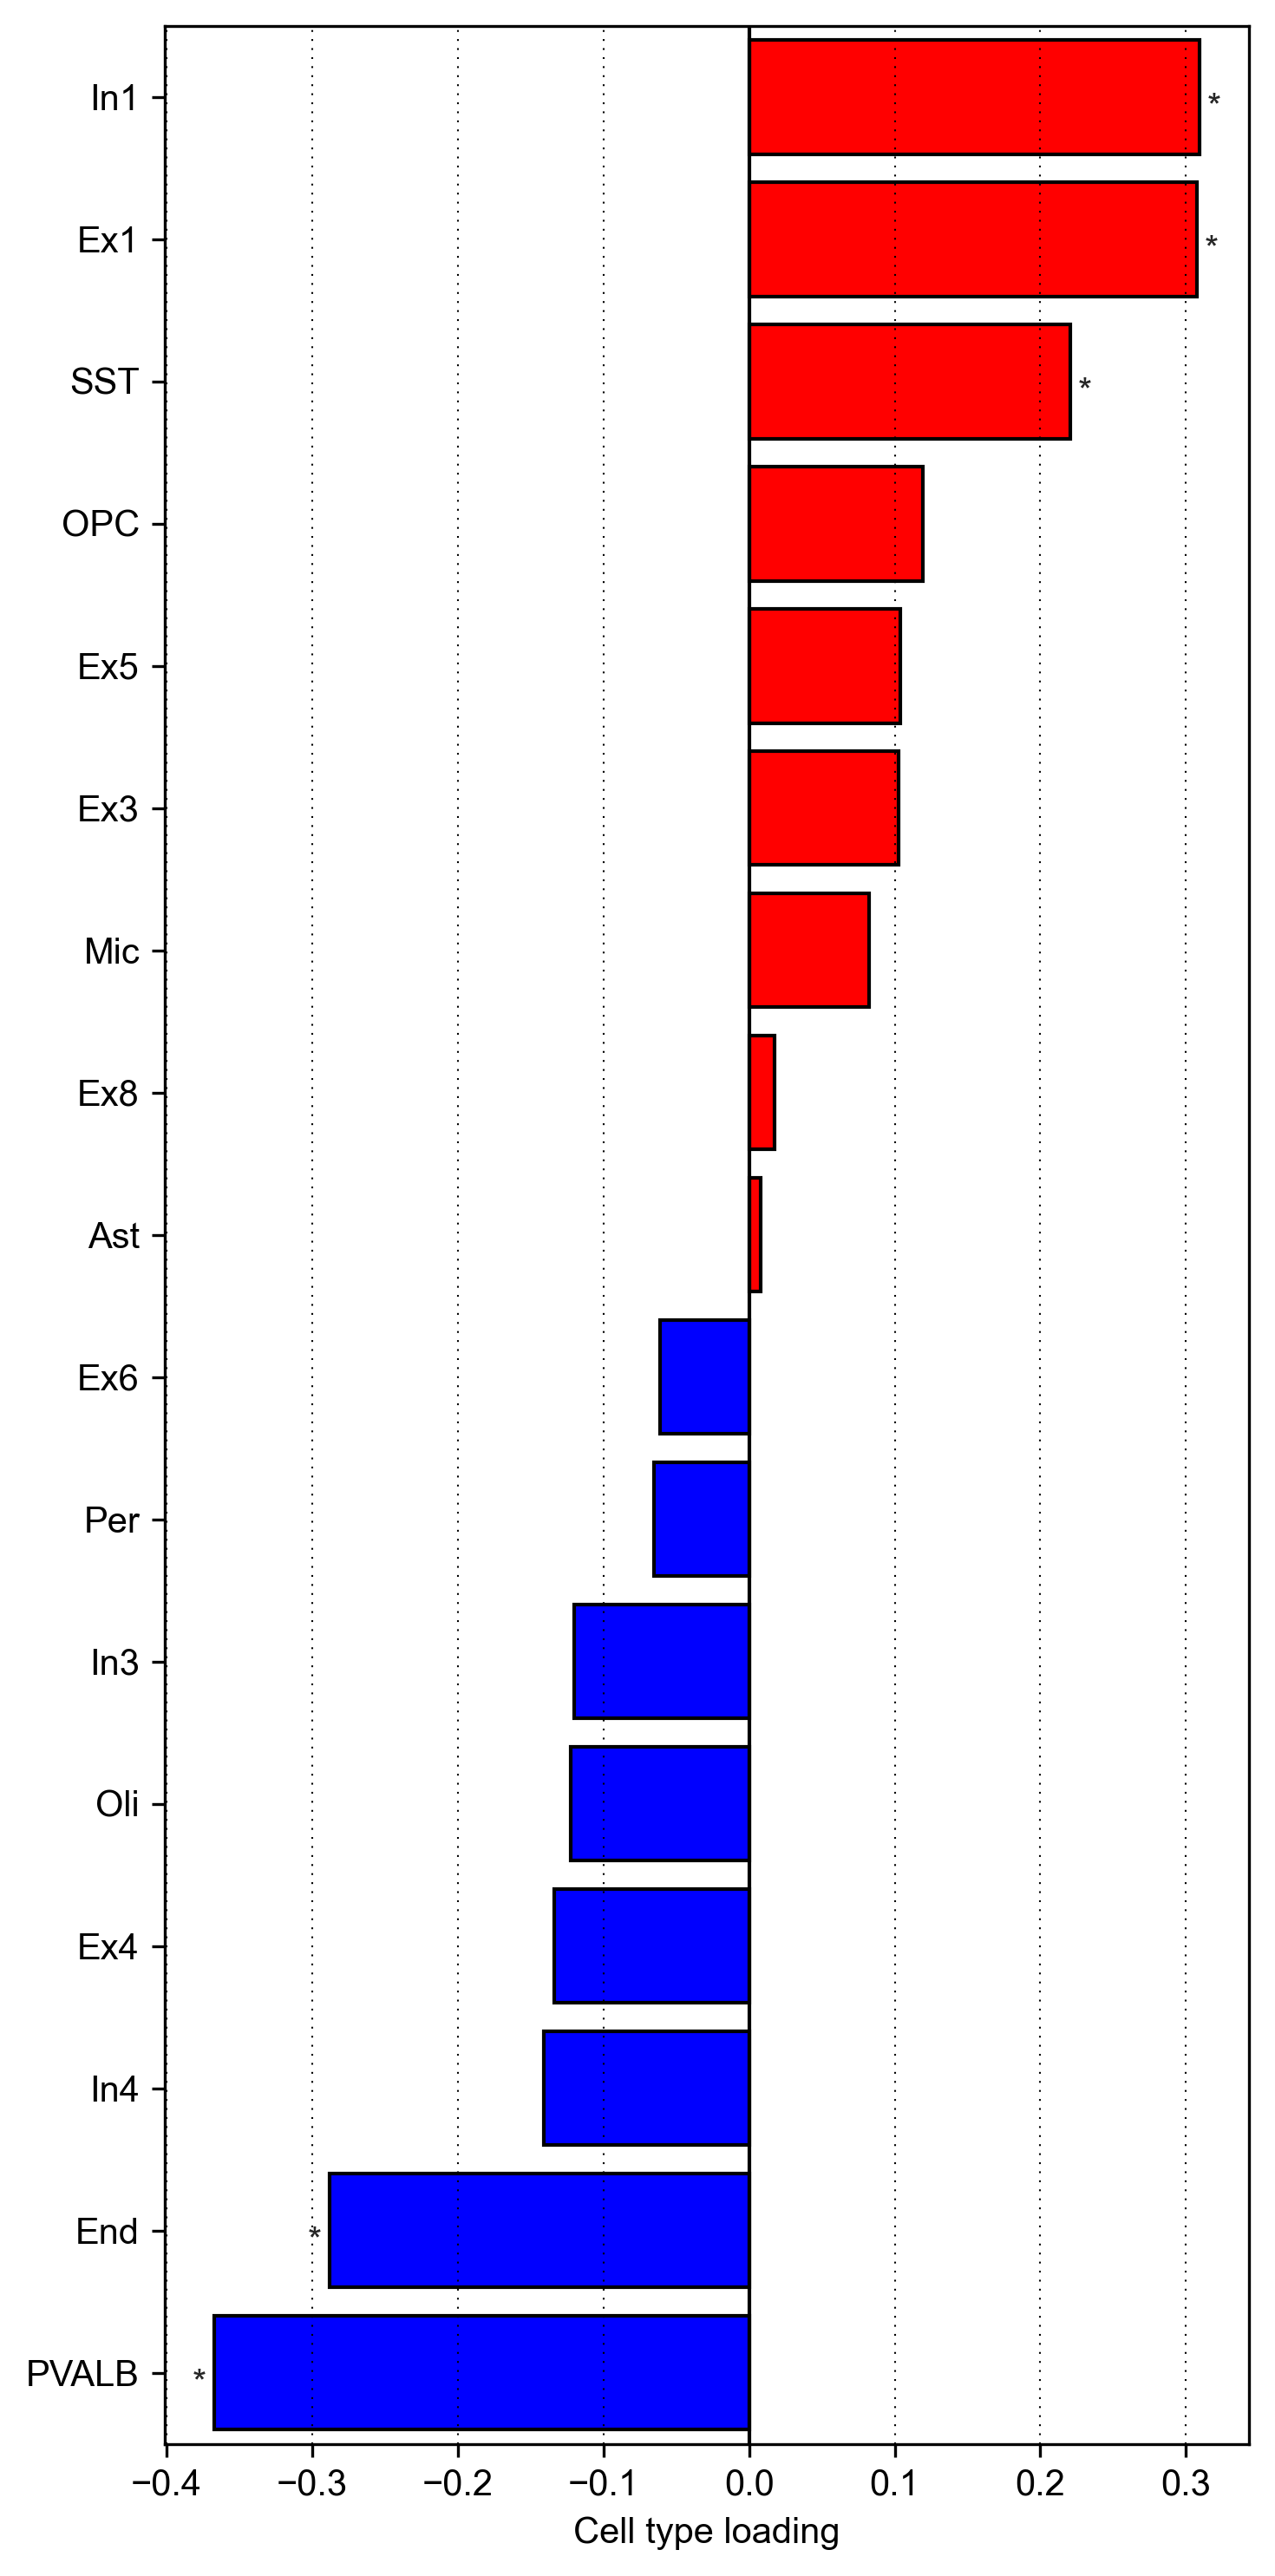

In [12]:
loading = 'loading_G1'
p = 'loading_G1_p'
# pull out the columns
table = loading_DFC_table[[loading,p]]
fig_name = 'loading_G1_DFC_DivergBar'
DivergingBarGraph(table, loading, p, fig_name)

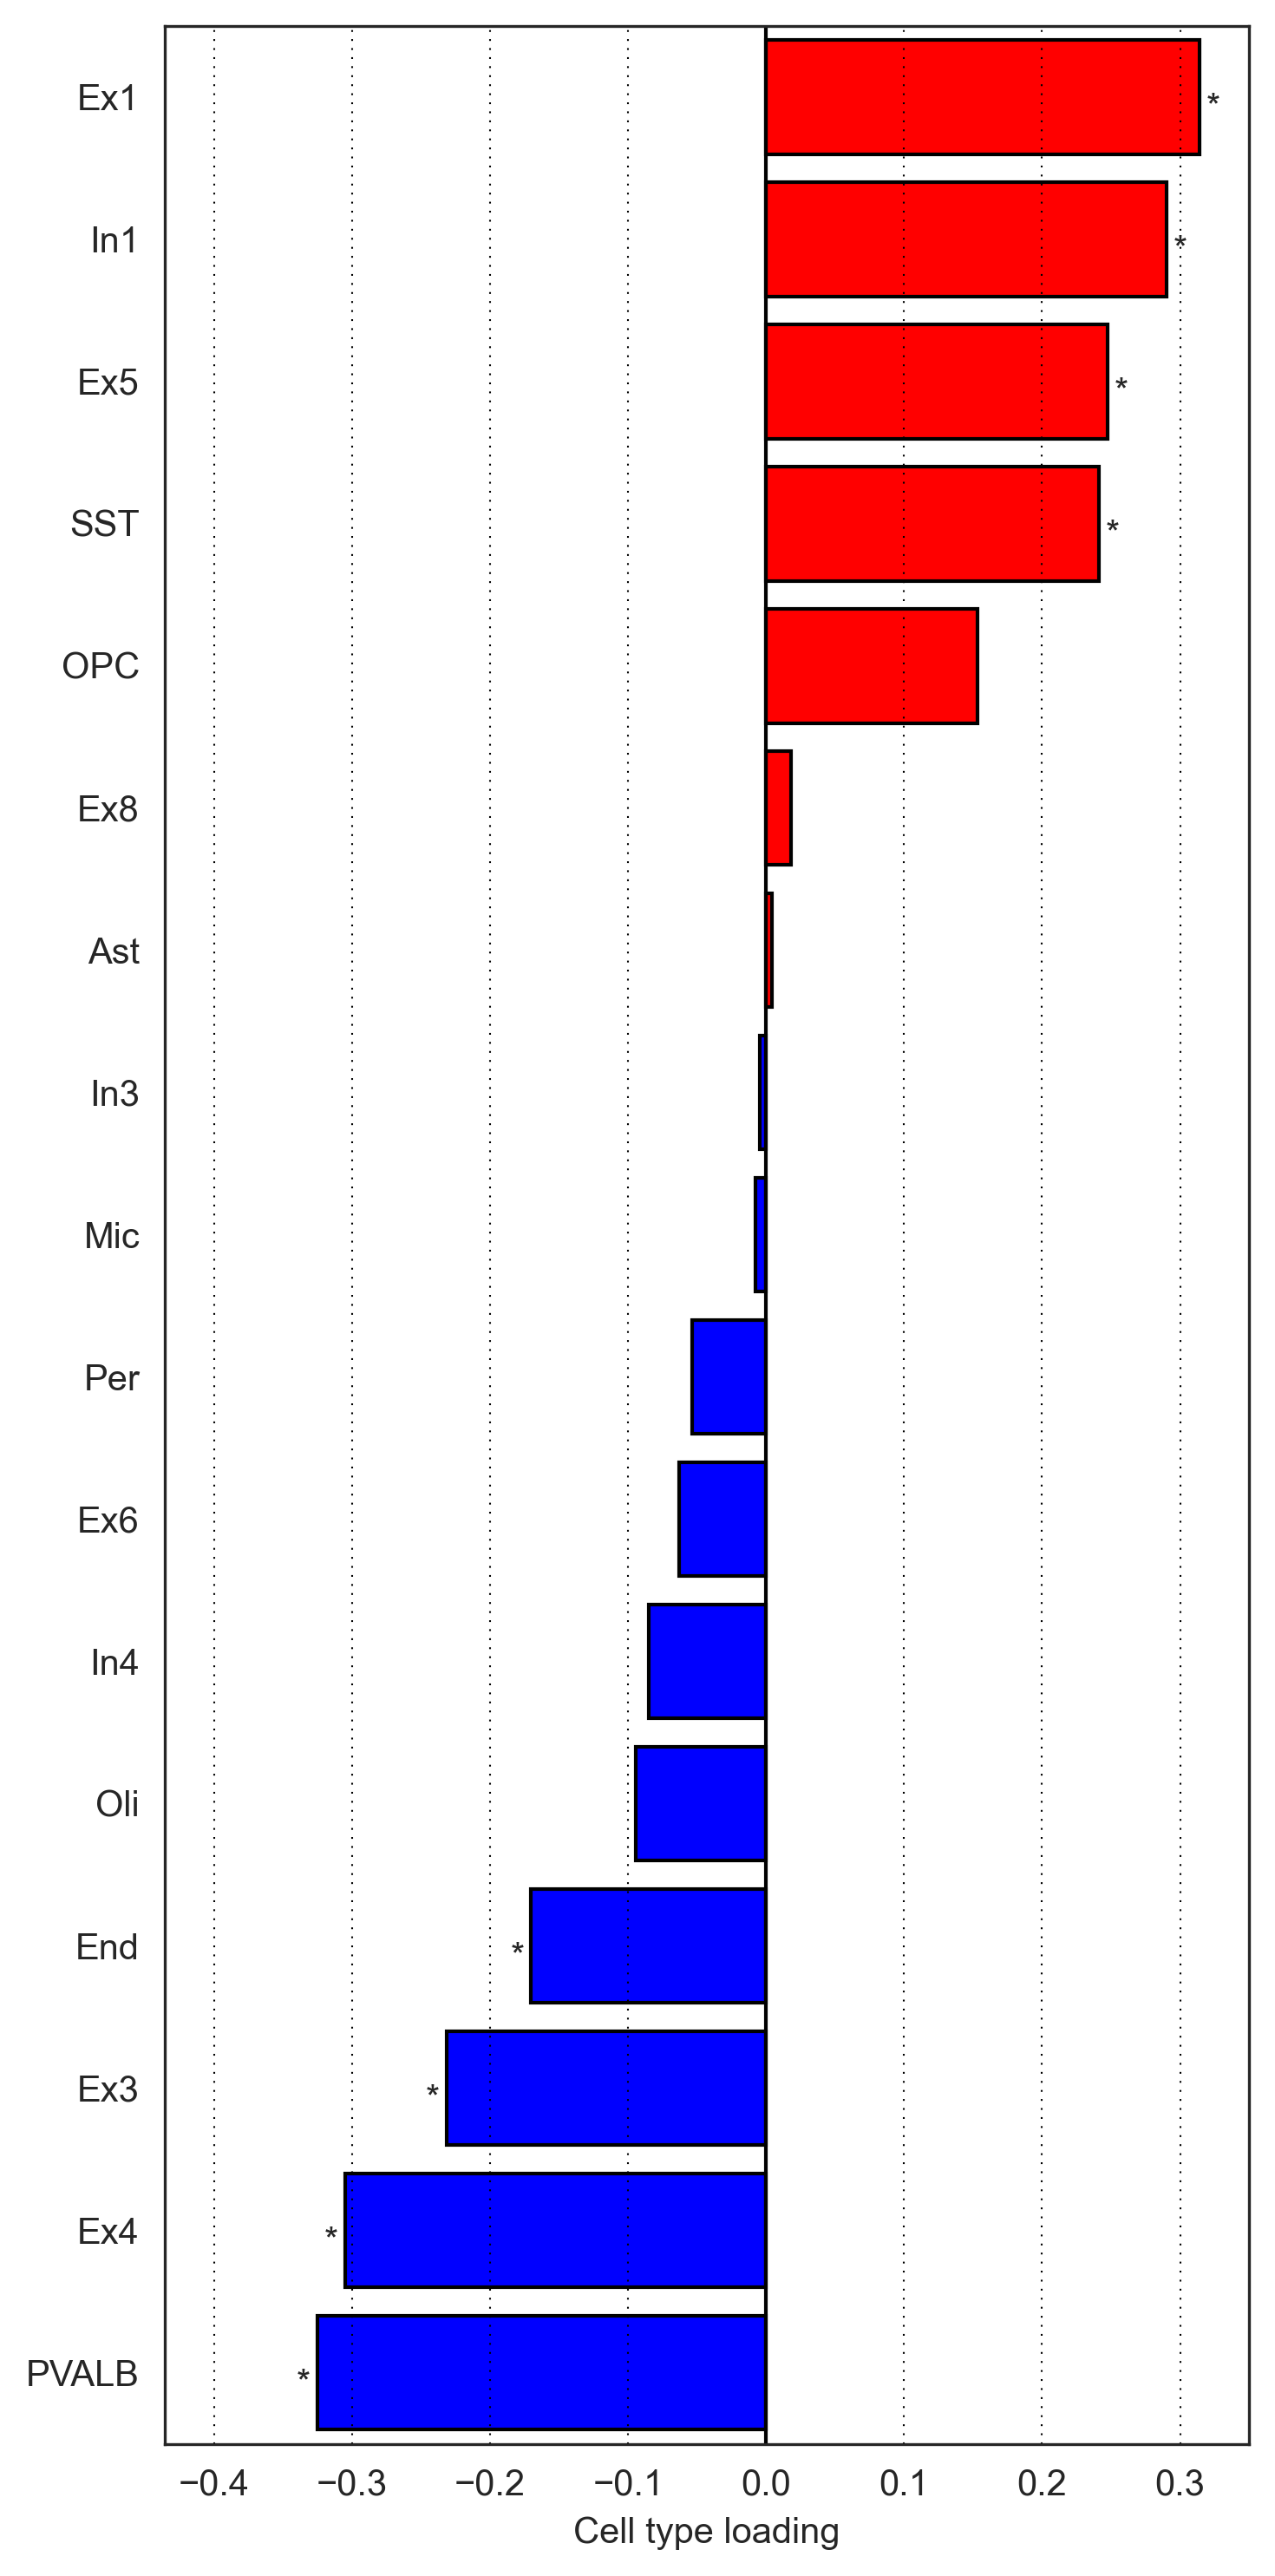

In [13]:
loading = 'loading_G1'
p = 'loading_G1_p'
# pull out the columns
table = loading_VIS_table[[loading,p]]
fig_name = 'loading_G1_VIS_DivergBar'
DivergingBarGraph(table, loading, p, fig_name)

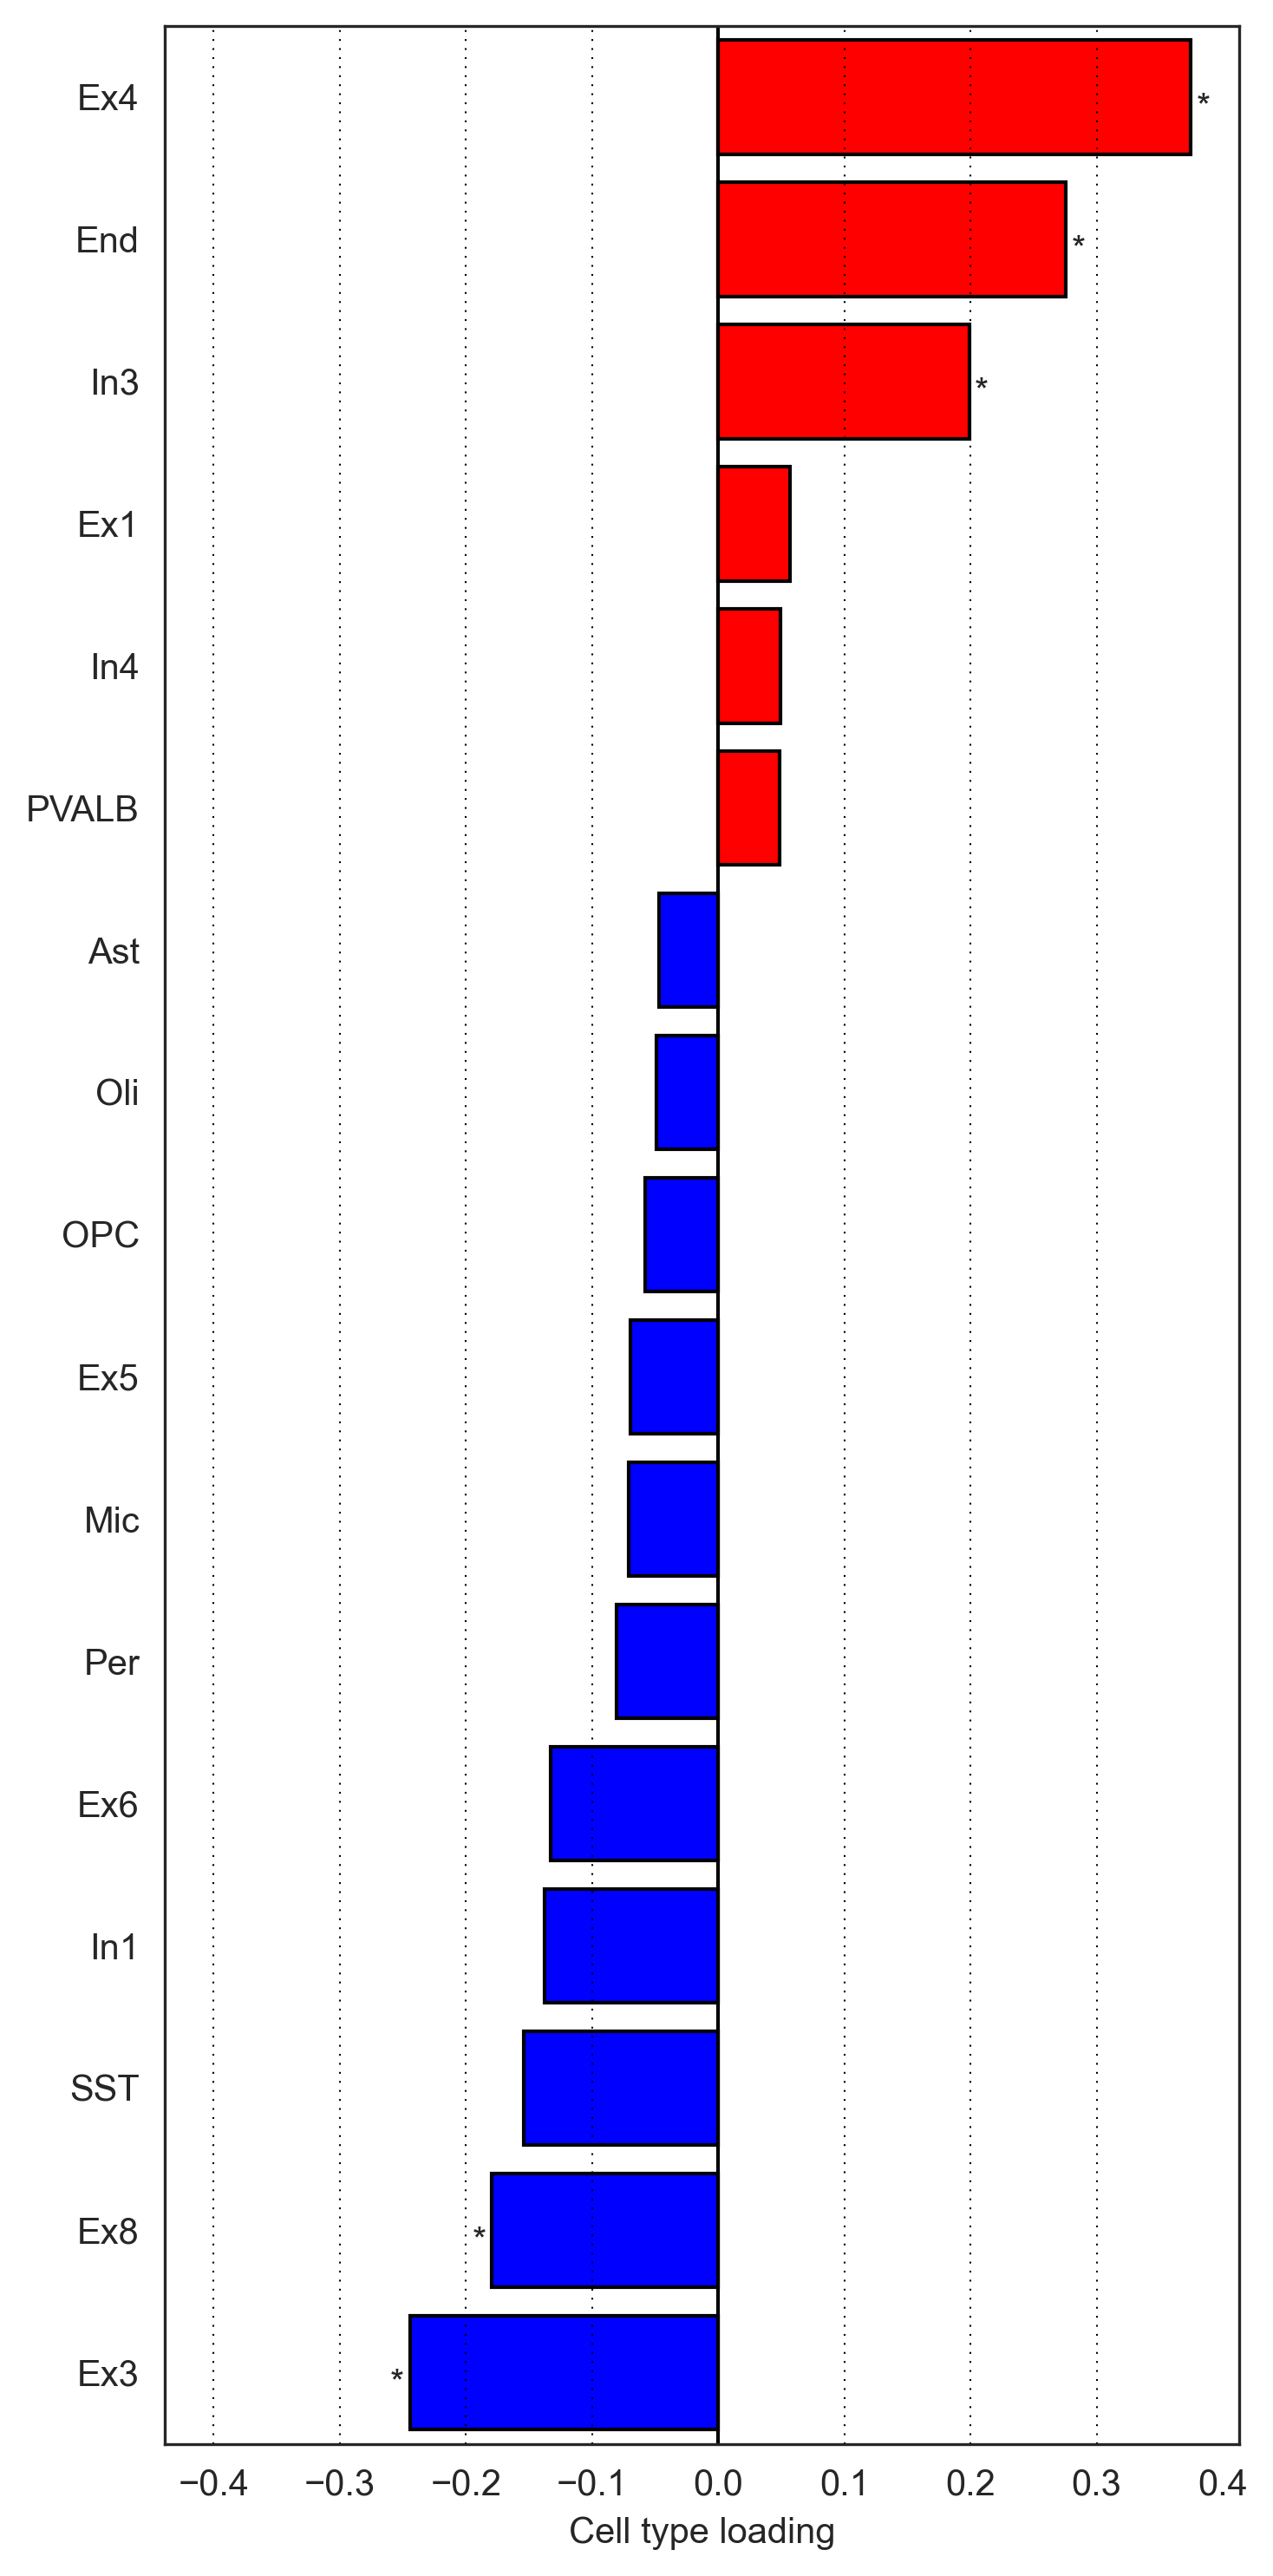

In [14]:
loading = 'loading_G2'
p = 'loading_G2_p'
# pull out the columns
table = loading_DFC_table[[loading,p]]
table['loading_G2'] = -table['loading_G2']
fig_name = 'loading_G2_DFC_DivergBar'
DivergingBarGraph(table, loading, p, fig_name)

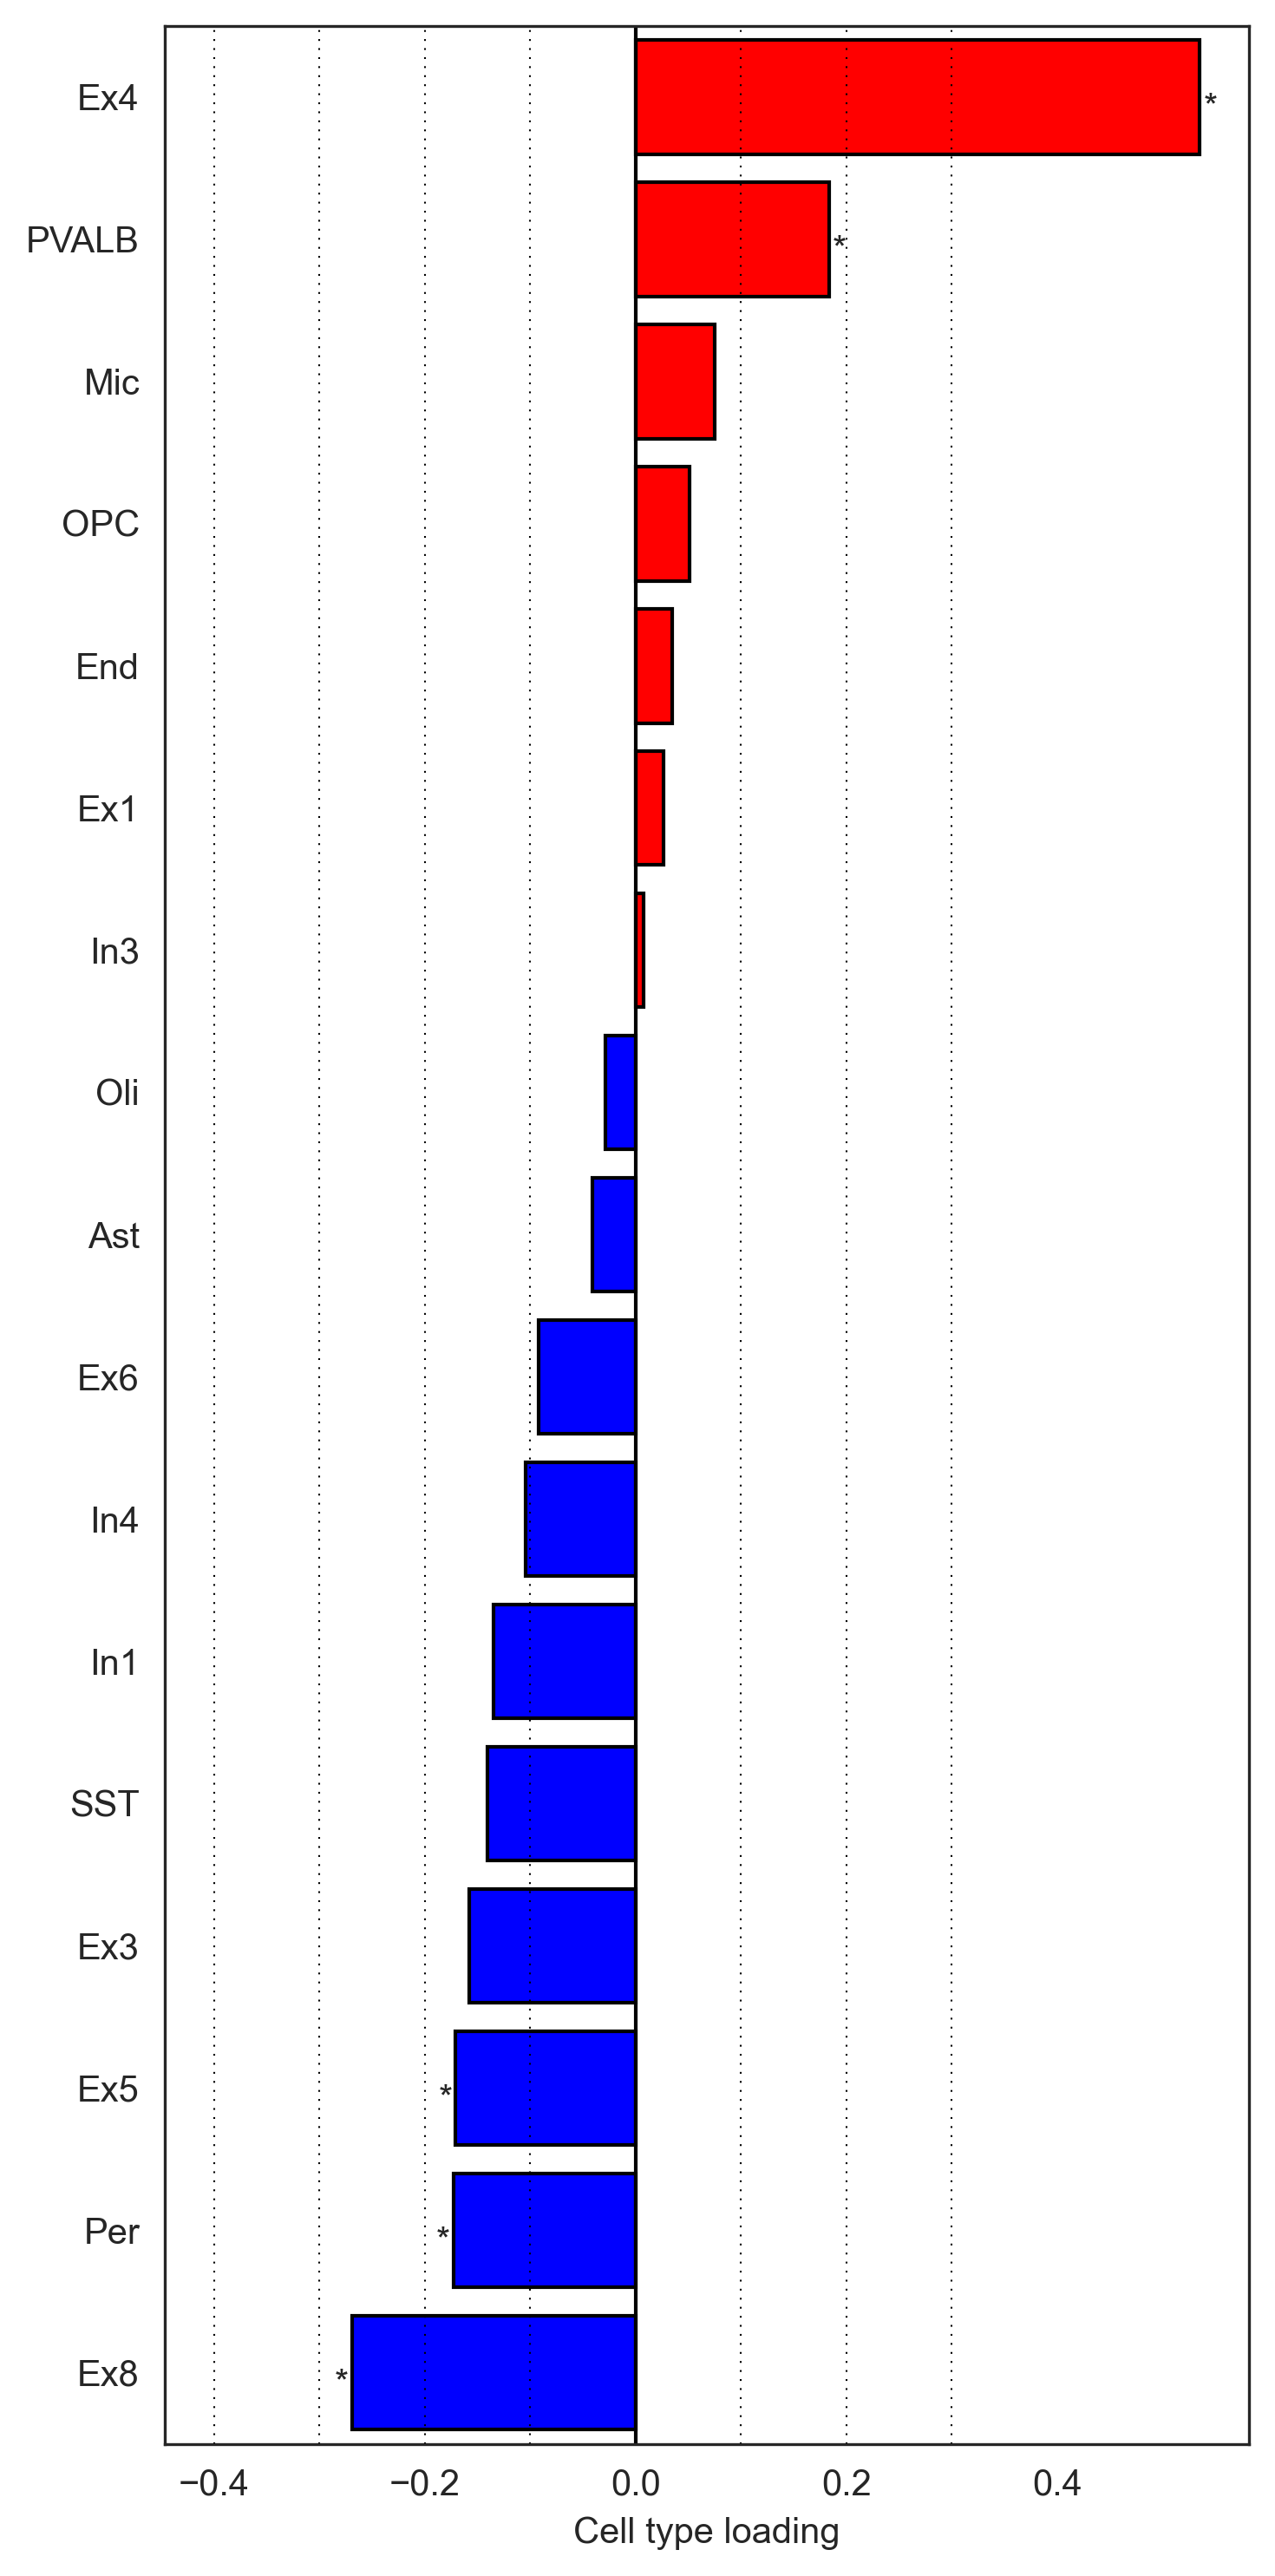

In [15]:
loading = 'loading_G2'
p = 'loading_G2_p'
# pull out the columns
table = loading_VIS_table[[loading,p]]
table['loading_G2'] = -table['loading_G2']
fig_name = 'loading_G2_VIS_DivergBar'
DivergingBarGraph(table, loading, p, fig_name)

## Scatter plot

In [18]:
def ScatterPlot(U,V,r,p,xlabel,ylabel,fig_name):
    # plot parameters:
    nrows = 1
    ncols = 1
    dpi = 300
    tight = True
    # set up the figure
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=[5,5], dpi=dpi, constrained_layout=tight)
    
    # make the bar plot
    sns.set_style(style="white")
    
    # make scatter plot
    sns.regplot(U, V, fit_reg=True, scatter=False,color="k")
    sns.scatterplot(U,V, sizes=30,legend=False)
    
    # set font size labels for x and y axis
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    
    # set font size for tick labels
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    
    # add r and p
    ax.set_title(f'r={r:.3f}, p={p:.3f}',fontsize=18)
    
    # save
    plt.savefig(figure_dir+f'/{fig_name}.pdf',bbox_inches="tight",transparent=True)
    

In [19]:
p_G1 = cca_p_r_table['G1_DFC'][0]
p_G2 = cca_p_r_table['G2_DFC'][0]
p_fdr = fdr([p_G1,p_G2], alpha=0.05, method='fdr_bh', is_sorted=False)[1]

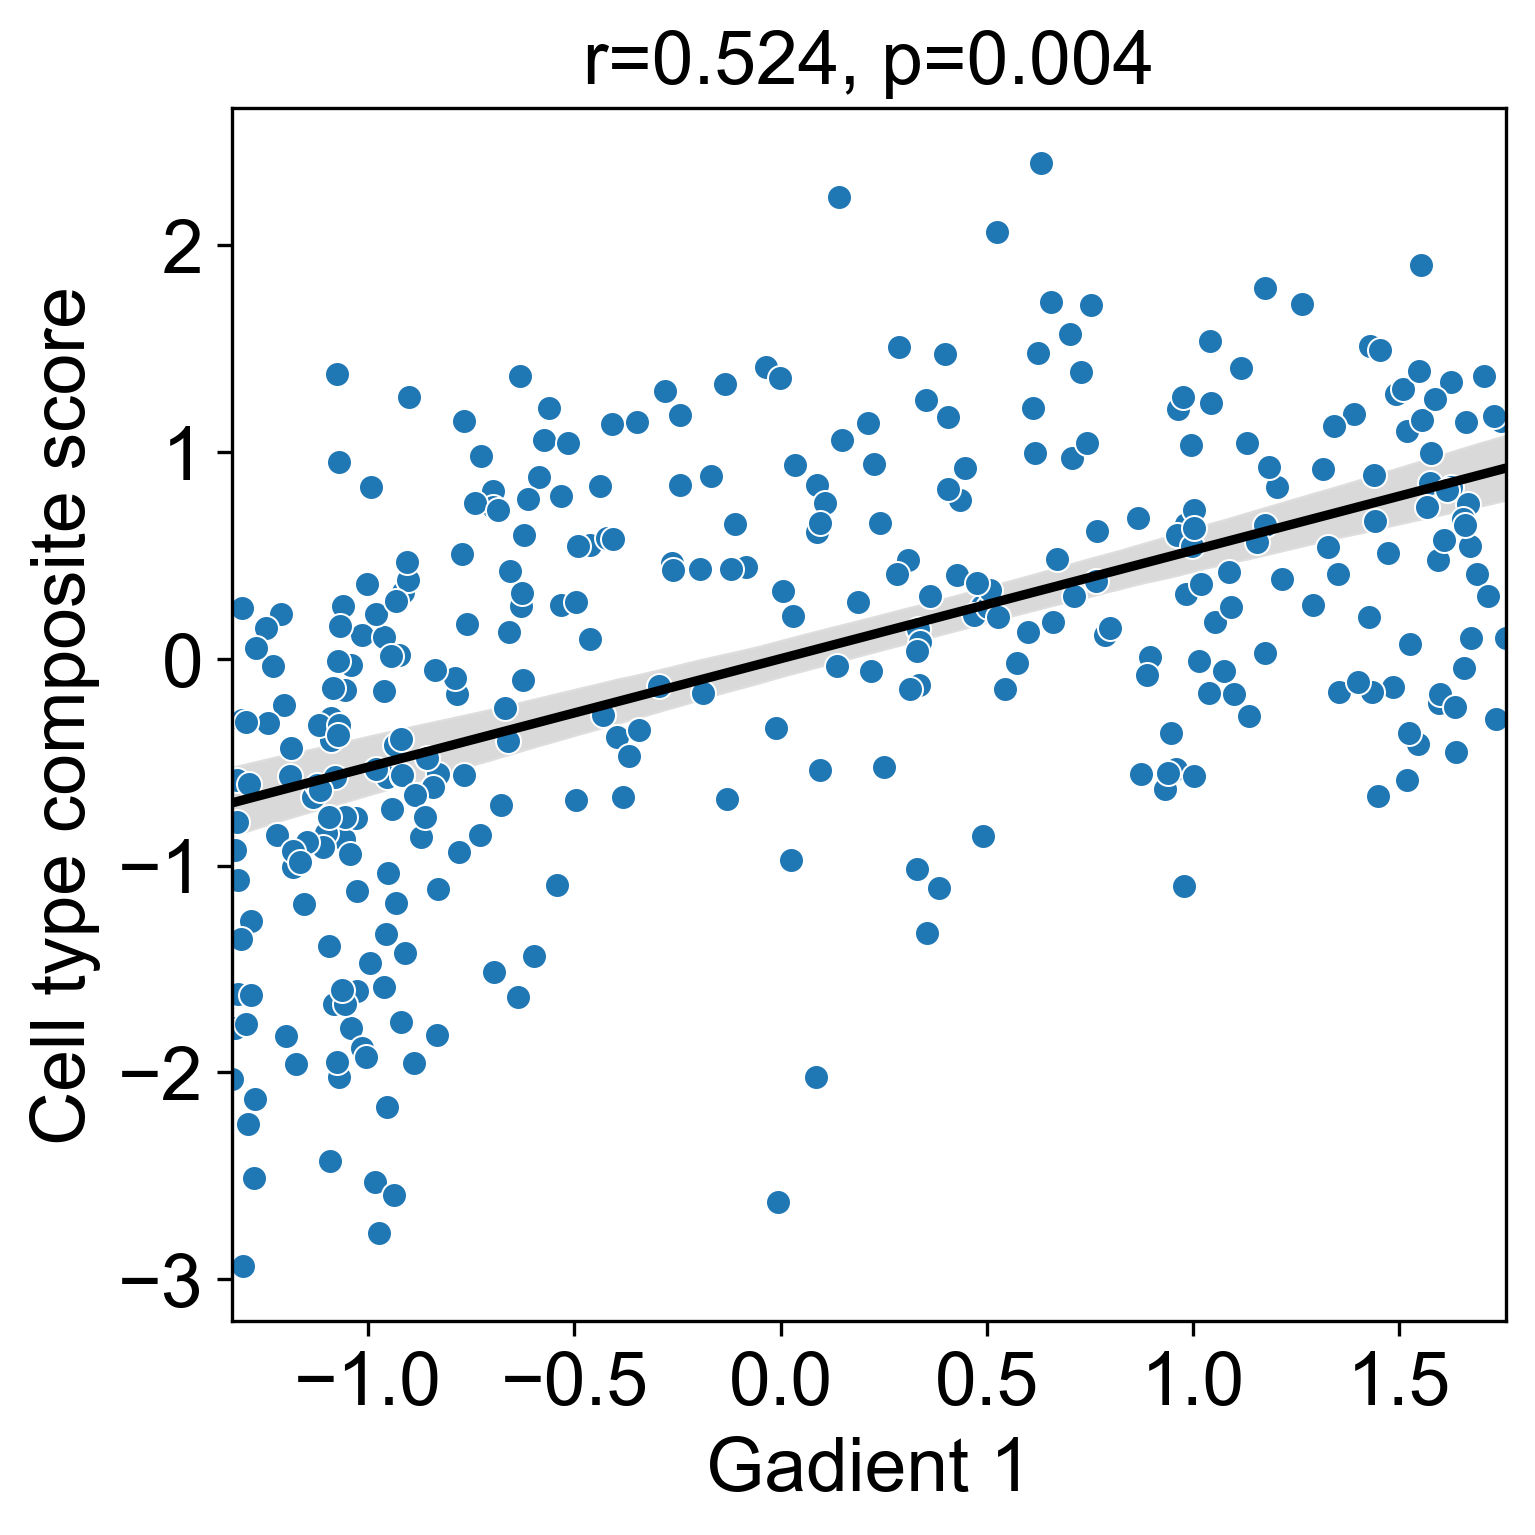

In [20]:
U = U_V_table['U_G1_DFC']
V = U_V_table['V_G1_DFC']

r = cca_p_r_table['G1_DFC'][1]
p = p_fdr[0]

xlabel = 'Gadient 1'
ylabel = 'Cell type composite score'

fig_name = 'U_V_G1_DFC_Scatter'

ScatterPlot(U,V,r,p,xlabel,ylabel,fig_name)

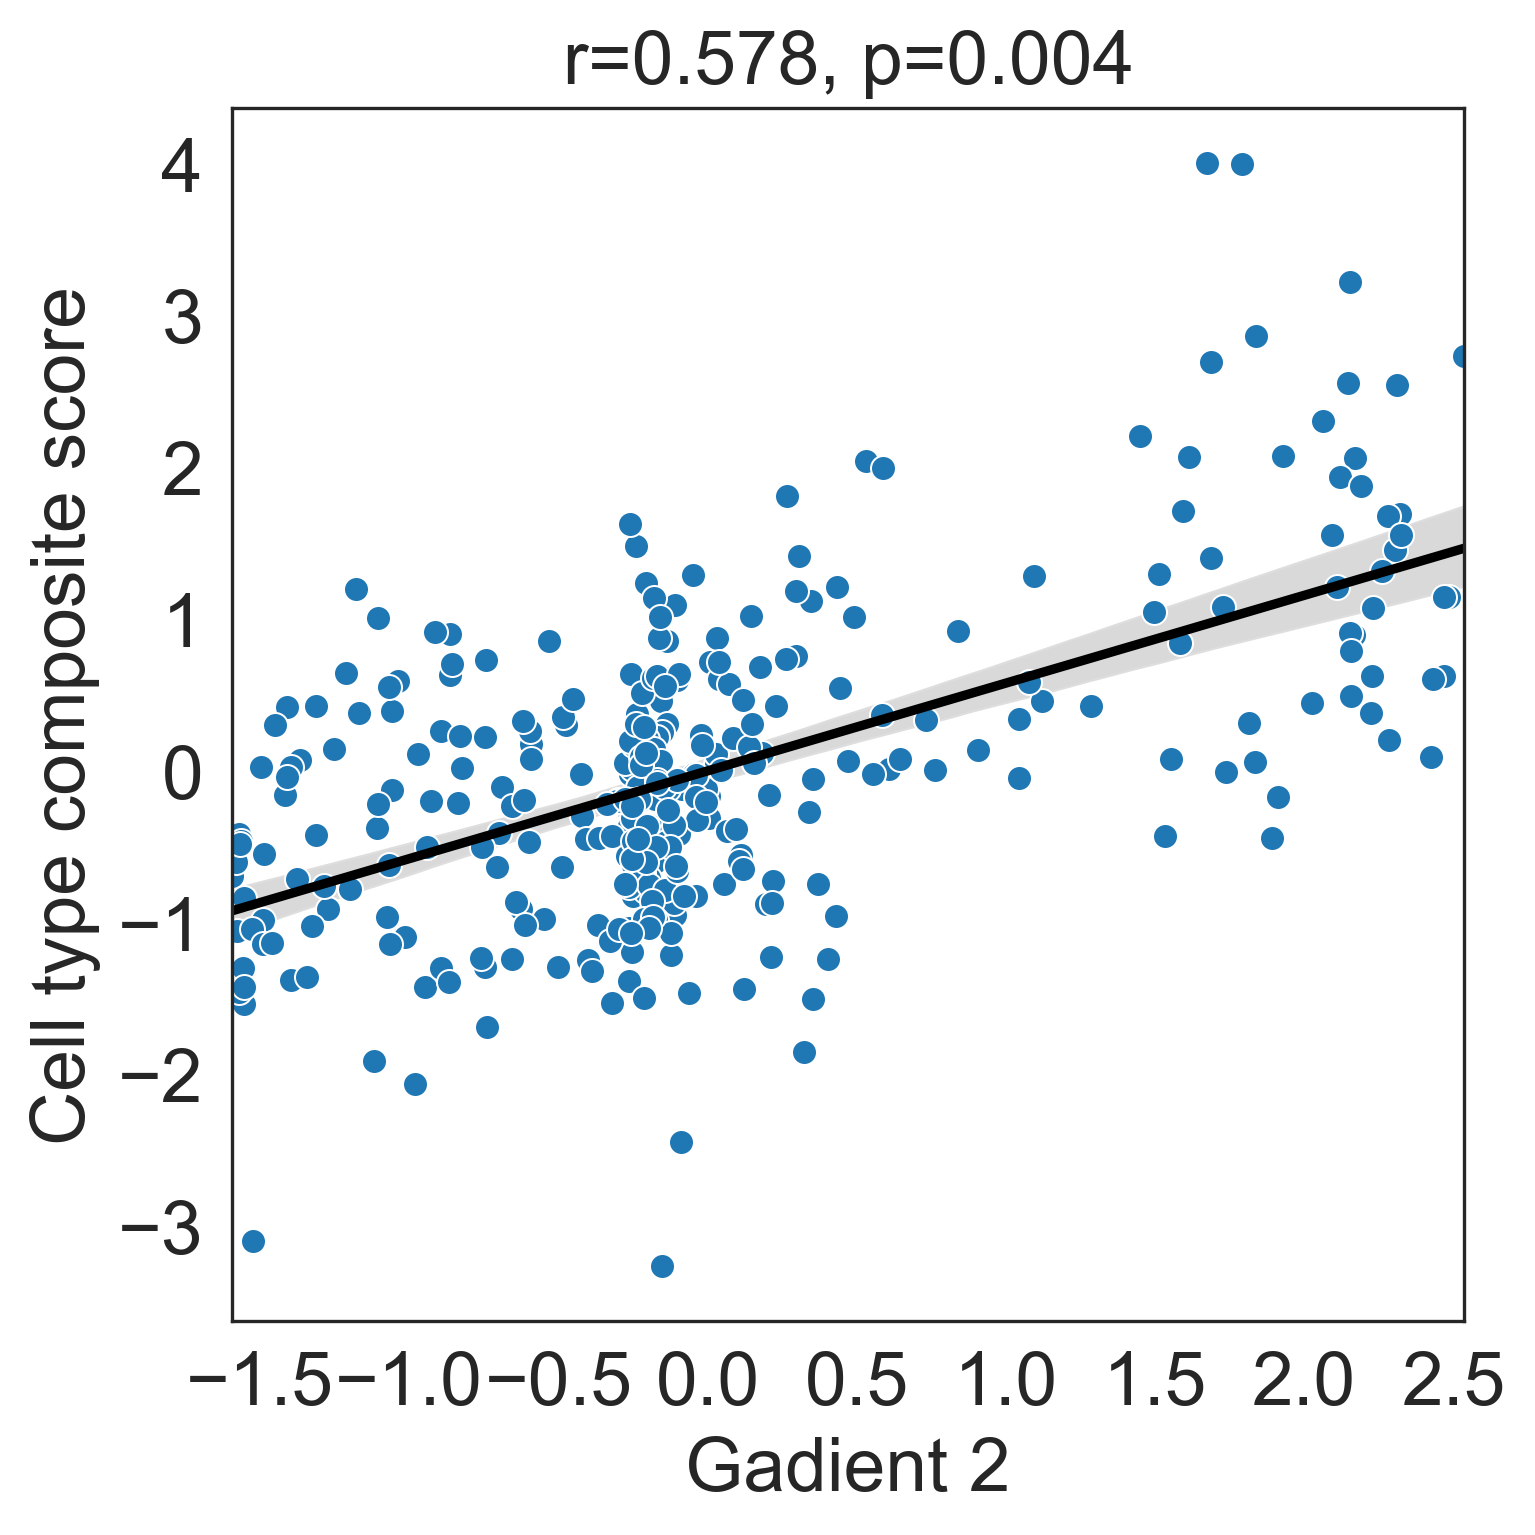

In [21]:
U = -U_V_table['U_G2_DFC']
V = -U_V_table['V_G2_DFC']

r = cca_p_r_table['G2_DFC'][1]
p = p_fdr[1]

xlabel = 'Gadient 2'
ylabel = 'Cell type composite score'

fig_name = 'U_V_G2_DFC_Scatter'

ScatterPlot(U,V,r,p,xlabel,ylabel,fig_name)

In [22]:
p_G1 = cca_p_r_table['G1_VIS'][0]
p_G2 = cca_p_r_table['G2_VIS'][0]
p_fdr = fdr([p_G1,p_G2], alpha=0.05, method='fdr_bh', is_sorted=False)[1]

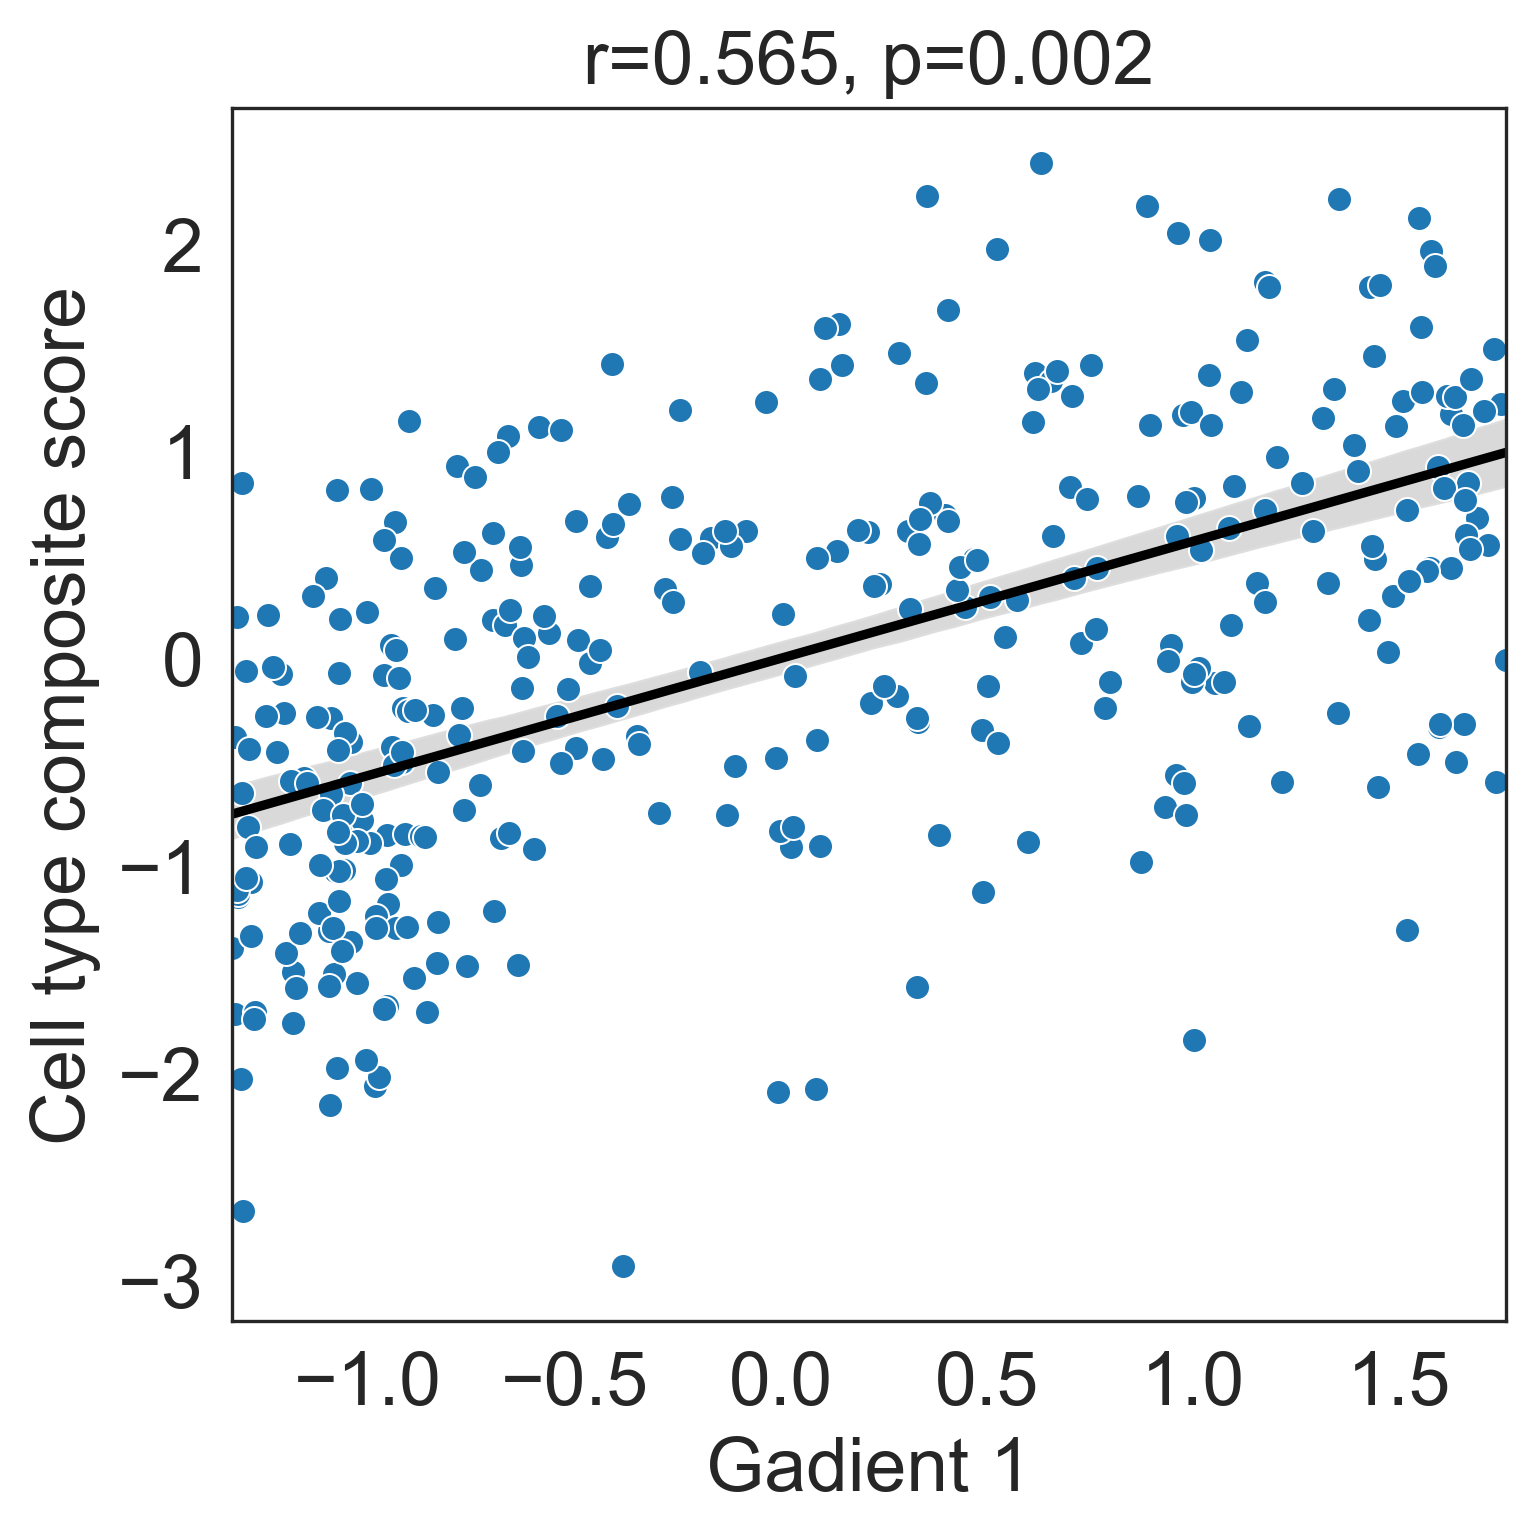

In [23]:
U = U_V_table['U_G1_VIS']
V = U_V_table['V_G1_VIS']

r = cca_p_r_table['G1_VIS'][1]
p = p_fdr[0]

xlabel = 'Gadient 1'
ylabel = 'Cell type composite score'

fig_name = 'U_V_G1_VIS_Scatter'

ScatterPlot(U,V,r,p,xlabel,ylabel,fig_name)

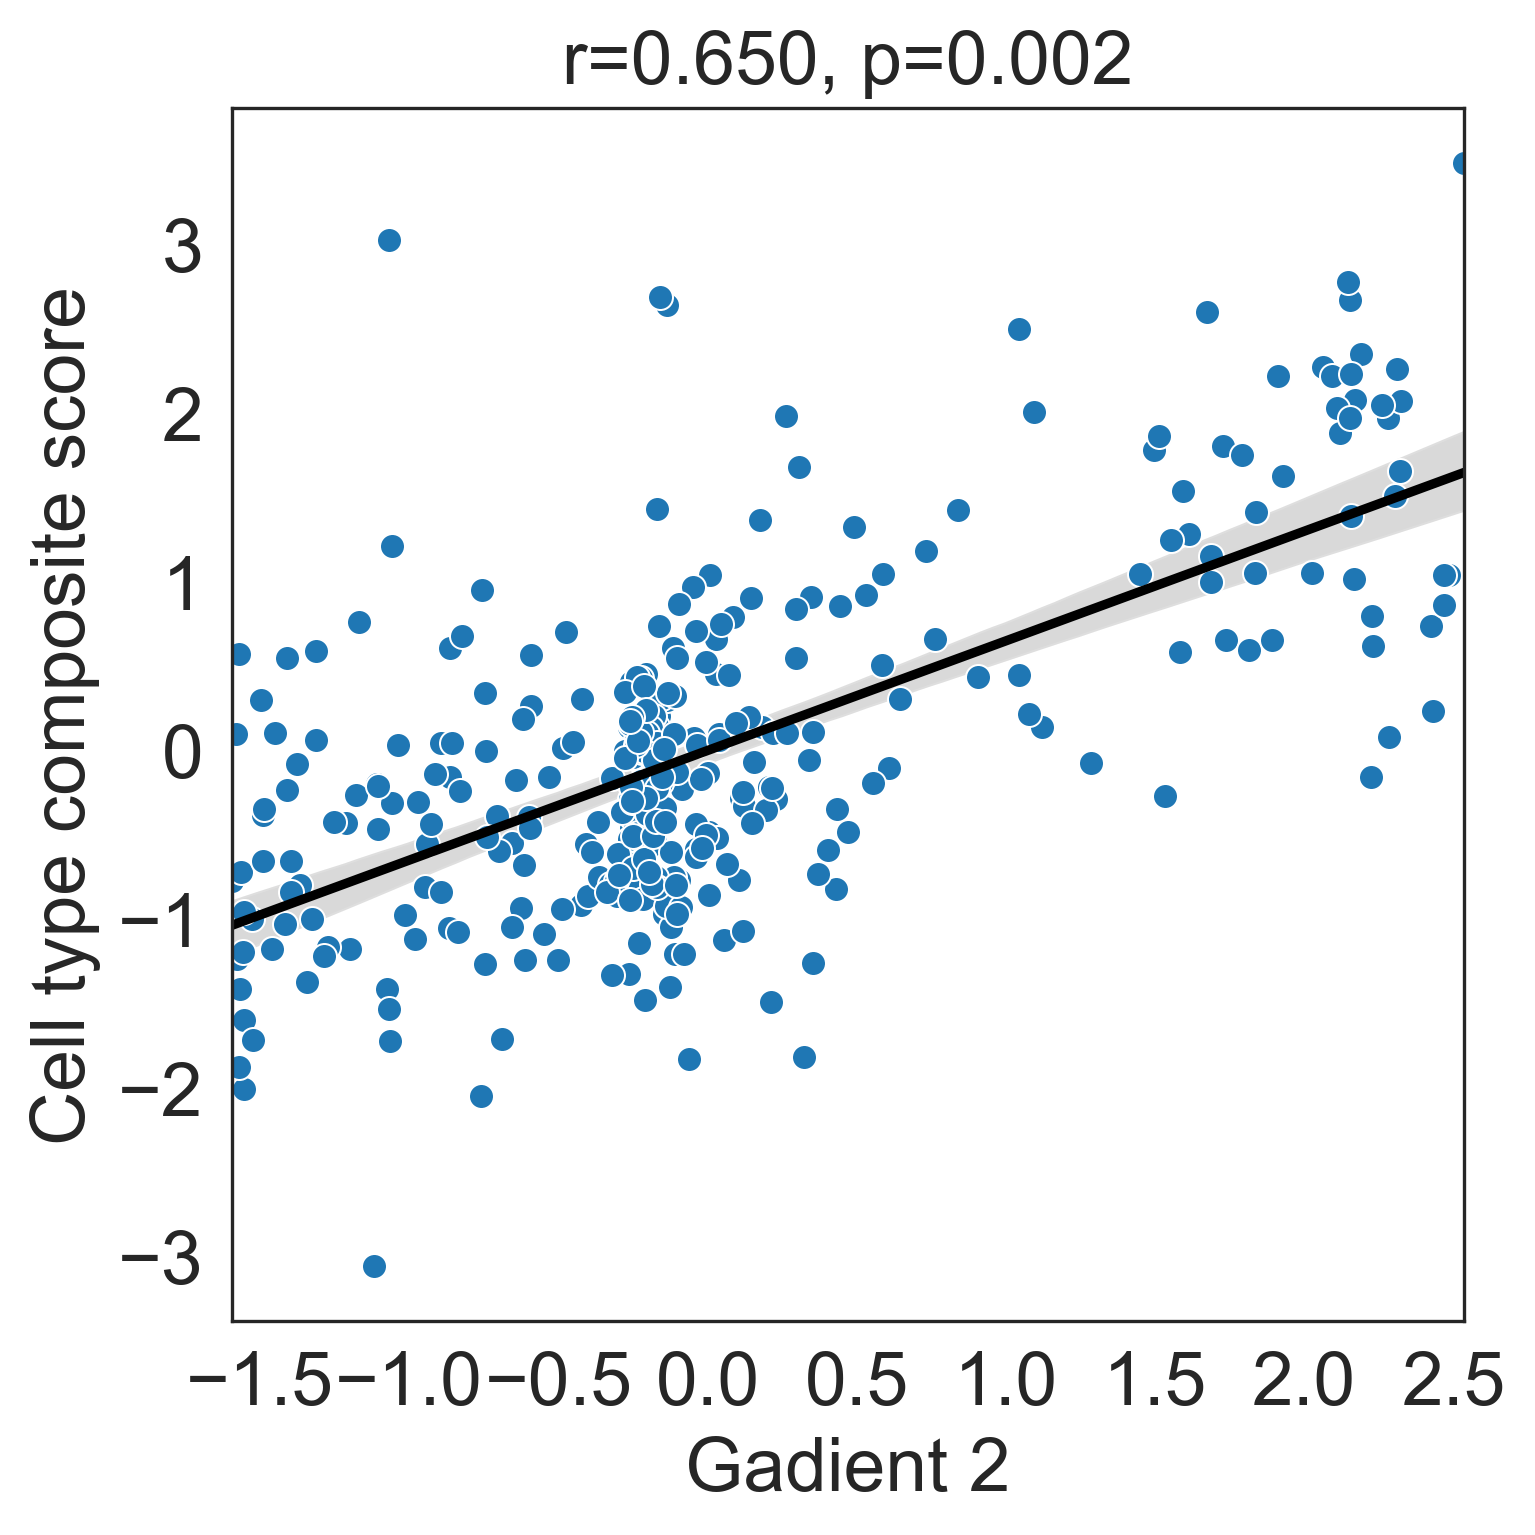

In [24]:
U = -U_V_table['U_G2_VIS']
V = -U_V_table['V_G2_VIS']

r = cca_p_r_table['G2_VIS'][1]
p = p_fdr[1]

xlabel = 'Gadient 2'
ylabel = 'Cell type composite score'

fig_name = 'U_V_G2_VIS_Scatter'

ScatterPlot(U,V,r,p,xlabel,ylabel,fig_name)

### FRD correction for gradual removal of cell types
#### Supplementary Table 1

In [25]:
p_DFC=[0.027,0.002,0.002,0.002,0.002,0.002,0.006,0.006,0.002,0.008,0.002,0.096]
p_fdr = fdr(p_DFC, alpha=0.05, method='fdr_bh', is_sorted=False)[1]
p_fdr

array([0.02945455, 0.00342857, 0.00342857, 0.00342857, 0.00342857,
       0.00342857, 0.008     , 0.008     , 0.00342857, 0.0096    ,
       0.00342857, 0.096     ])

In [27]:
p_VIS=[0.002,0.002,0.002,0.001,0.002,0.001,0.002,0.002,0.001,0.001]
p_fdr = fdr(p_VIS, alpha=0.05, method='fdr_bh', is_sorted=False)[1]
p_fdr

array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002])

#### Supplementary Table 2

In [28]:
p_DFC=[0.036,0.040,0.220]
p_fdr = fdr(p_DFC, alpha=0.05, method='fdr_bh', is_sorted=False)[1]
p_fdr

array([0.06, 0.06, 0.22])

## Plot the correlation matrix for cell type abundance across parcels

In [24]:
cell_types_DFC

['DFC_Ex1',
 'DFC_Ex3',
 'DFC_Ex4',
 'DFC_Ex5',
 'DFC_Ex6',
 'DFC_Ex8',
 'DFC_In1',
 'DFC_In3',
 'DFC_In4',
 'DFC_PVALB',
 'DFC_SST',
 'DFC_End',
 'DFC_Per',
 'DFC_Ast',
 'DFC_Oli',
 'DFC_OPC',
 'DFC_Mic']

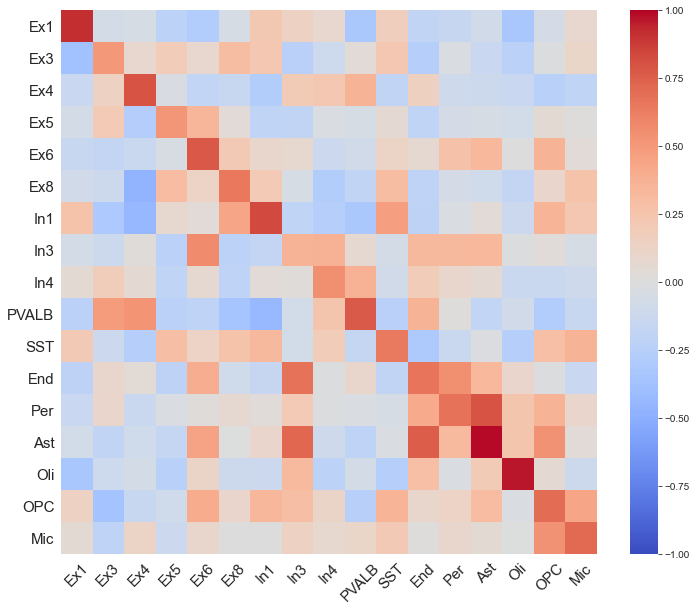

In [55]:
cell_num = 17
file_name_mat = figure_dir+'/Cell_Abundance_Corelation_Matrix.pdf'
cell_types = [name.replace("DFC_", "") for name in cell_types_DFC]

fontprops = fm.FontProperties(size=15)

correlation_matrix = np.zeros((cell_num, cell_num))
for i in range(cell_num):
    for j in range(cell_num):
        if i == j:
            correlation_matrix[i][j] = pearsonr(LakeDFC_schaefer400_mat[i], LakeVIS_schaefer400_mat[j])[0]
        elif i < j:  # Upper triangle: Lake_DFC
            correlation_matrix[i][j] = pearsonr(LakeDFC_schaefer400_mat[i], LakeDFC_schaefer400_mat[j])[0]
        else:  # Lower triangle: Lake_VIS
            correlation_matrix[i][j] = pearsonr(LakeVIS_schaefer400_mat[i], LakeVIS_schaefer400_mat[j])[0]

plt.figure(figsize=(12,10))
ax = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
ax.set_xticklabels(cell_types, rotation=45, fontproperties=fontprops)
ax.set_yticklabels(cell_types, rotation=0, fontproperties=fontprops)
plt.savefig(file_name_mat)
plt.show()